Using device: cuda
✅ Special tokens bound: 0 1 2 3 4


Processing Inputs:   0%|          | 0/4 [00:00<?, ?input/s]

Generating for O=C(C[C@@H]1N([...:   0%|          | 0/50 [00:00<?, ?mol/s]

Generating for O=C(C[C@@H]1N([...:  43%|████▎     | 43/100 [01:08<01:31,  1.60s/mol]


Generating for O=C2N(C)[C@H](c...:   0%|          | 0/50 [00:00<?, ?mol/s]

Generating for O=C1/C=C\C=C2/N...:   0%|          | 0/50 [00:00<?, ?mol/s]

Generating for n1c2cc3c(cc2ncc...:   0%|          | 0/50 [00:00<?, ?mol/s]


=== Summary ===
Total generated: 200
Overall validity rate: 100.00%

Input: O=C(C[C@@H]1N([C@@H](CCC1)C[C@@H](C2=CC=CC=C2)O)C)C3=CC=CC=C3
  Validity: 100.00%
  Avg Similarity: 0.626
  Lipinski Pass Rate: 38.00%

Input: O=C2N(C)[C@H](c1cnccc1)CC2
  Validity: 100.00%
  Avg Similarity: 0.418
  Lipinski Pass Rate: 94.00%

Input: O=C1/C=C\C=C2/N1C[C@@H]3CNC[C@H]2C3
  Validity: 100.00%
  Avg Similarity: 0.598
  Lipinski Pass Rate: 98.00%

Input: n1c2cc3c(cc2ncc1)[C@@H]4CNC[C@H]3C4
  Validity: 100.00%
  Avg Similarity: 0.475
  Lipinski Pass Rate: 96.00%

Running t-SNE...


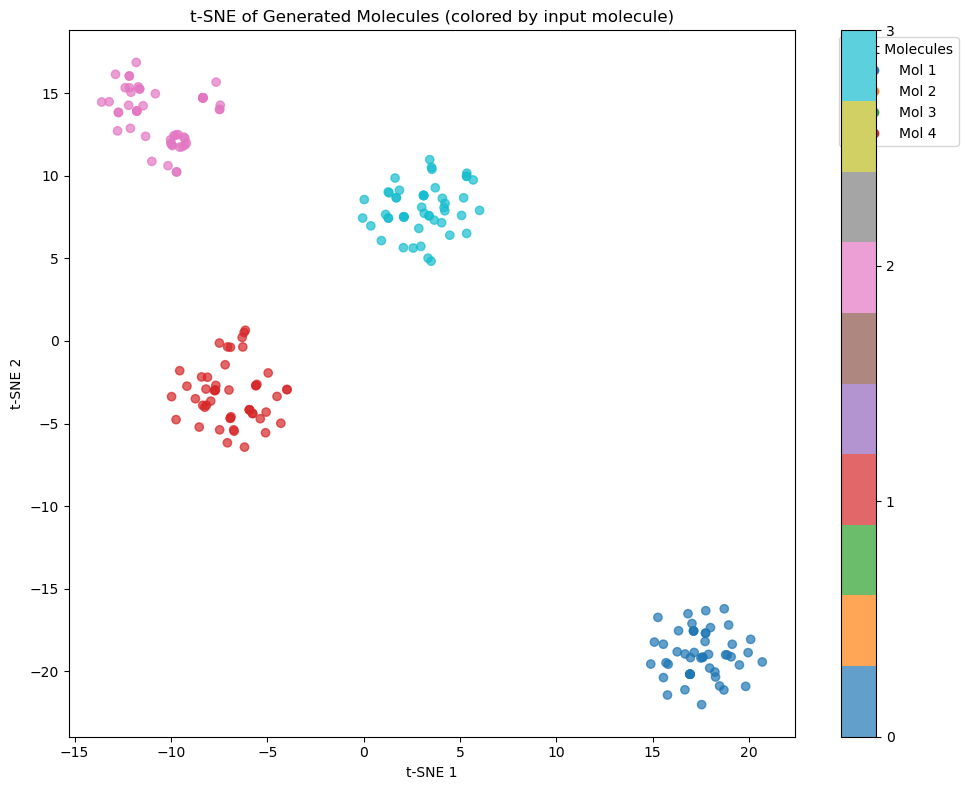


Results saved to 'generation_evaluation_results.csv'


In [2]:
import torch
import selfies as sf
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import sys
from tqdm.notebook import tqdm

# ----------------------------
# Setup (same as before)
# ----------------------------

notebook_dir = os.getcwd()
chemq3mtp_path = os.path.join(notebook_dir, "ChemQ3MTP")
if chemq3mtp_path not in sys.path:
    sys.path.insert(0, chemq3mtp_path)

existing_paths = [p for p in sys.path if p.endswith("ChemQ3MTP")]
for path in existing_paths[:-1]:
    sys.path.remove(path)

from FastChemTokenizerHF import FastChemTokenizerSelfies
from ChemQ3MTP import ChemQ3MTPForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = FastChemTokenizerSelfies.from_pretrained('./selftok_core/')
model = ChemQ3MTPForCausalLM.from_pretrained("./ChemQ").to(device).eval()
if hasattr(model, 'set_mtp_training'):
    model.set_mtp_training(False)

# ----------------------------
# Utility Functions (same)
# ----------------------------

def smiles_to_selfies_safe(smiles):
    try:
        return sf.encoder(smiles)
    except:
        return None

def selfies_to_smiles_safe(selfies):
    try:
        return sf.decoder(selfies)
    except:
        return None

def process_selfies_sentence(selfies_str):
    try:
        tokens = list(sf.split_selfies(selfies_str))
        joined = []
        i = 0
        while i < len(tokens):
            if tokens[i] == '.' and i + 1 < len(tokens):
                joined.append(f".{tokens[i+1]}")
                i += 2
            else:
                joined.append(tokens[i])
                i += 1
        return ' '.join(joined)
    except:
        return None

def generate_selfies(input_selfies, max_new_tokens=64):
    processed = process_selfies_sentence(input_selfies)
    if processed is None:
        return None
    enc = tokenizer(
        processed,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    with torch.no_grad():
        gen = model.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            max_new_tokens=max_new_tokens,
            top_k=50,
            temperature=1.0,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(gen[0], skip_special_tokens=True).replace(" ", "")
    return decoded

def is_valid_smiles(smiles):
    return Chem.MolFromSmiles(smiles) is not None

def compute_morgan_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def tanimoto_sim(fp1, fp2):
    if fp1 is None or fp2 is None:
        return 0.0
    return Chem.DataStructs.TanimotoSimilarity(fp1, fp2)

def lipinski_pass(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    return all([
        mw <= 500,
        logp <= 5,
        hbd <= 5,
        hba <= 10
    ])

# ----------------------------
# Main Evaluation with selective tqdm
# ----------------------------

test_smiles = [
    "O=C(C[C@@H]1N([C@@H](CCC1)C[C@@H](C2=CC=CC=C2)O)C)C3=CC=CC=C3",           # Lobeline
    "O=C2N(C)[C@H](c1cnccc1)CC2",       # Cotinine
    "O=C1/C=C\\C=C2/N1C[C@@H]3CNC[C@H]2C3",      # Cytisine
    "n1c2cc3c(cc2ncc1)[C@@H]4CNC[C@H]3C4",        # Varenicline
]

results = []
all_fps = []
all_labels = []

N_PER_INPUT = 50
BATCHES = 5
BATCH_SIZE = N_PER_INPUT // BATCHES

# Outer progress bar: over input molecules
for input_idx, input_smi in enumerate(tqdm(test_smiles, desc="Processing Inputs", unit="input")):
    input_selfies = smiles_to_selfies_safe(input_smi)
    if input_selfies is None:
        print(f"⚠️ Skipping invalid input: {input_smi}")
        continue

    input_fp = compute_morgan_fp(input_smi)
    generated_smiles_list = []

    # Progress bar for generating 100 molecules for this input
    pbar = tqdm(
        total=N_PER_INPUT,
        desc=f"Generating for {input_smi[:15]}...",
        unit="mol"
    )

    for _ in range(BATCHES):
        for _ in range(BATCH_SIZE):
            try:
                out_selfies = generate_selfies(input_selfies, max_new_tokens=64)
                if out_selfies:
                    out_smi = selfies_to_smiles_safe(out_selfies)
                    if out_smi:
                        generated_smiles_list.append(out_smi)
            except Exception:
                pass  # Silent fail; pbar still increments
            pbar.update(1)
    pbar.close()

    # Evaluate each generated molecule (no progress bar - fast operation)
    for gen_smi in generated_smiles_list:
        valid = is_valid_smiles(gen_smi)
        gen_fp = compute_morgan_fp(gen_smi) if valid else None
        sim = tanimoto_sim(input_fp, gen_fp) if valid and input_fp else 0.0
        lipinski_ok = lipinski_pass(gen_smi) if valid else False

        results.append({
            "input_smiles": input_smi,
            "generated_smiles": gen_smi,
            "valid": valid,
            "similarity": sim,
            "lipinski_pass": lipinski_ok,
            "input_index": input_idx
        })

        if valid and gen_fp is not None:
            all_fps.append(np.array(gen_fp))
            all_labels.append(input_idx)

# ----------------------------
# Summary & t-SNE (updated legend)
# ----------------------------

df = pd.DataFrame(results)
print("\n=== Summary ===")
print(f"Total generated: {len(df)}")
print(f"Overall validity rate: {df['valid'].mean():.2%}")

for idx, smi in enumerate(test_smiles):
    subset = df[df['input_index'] == idx]
    if len(subset) > 0:
        avg_sim = subset['similarity'].mean()
        lip_rate = subset['lipinski_pass'].mean()
        val_rate = subset['valid'].mean()
        print(f"\nInput: {smi}")
        print(f"  Validity: {val_rate:.2%}")
        print(f"  Avg Similarity: {avg_sim:.3f}")
        print(f"  Lipinski Pass Rate: {lip_rate:.2%}")

# t-SNE
if len(all_fps) > 0:
    print("\nRunning t-SNE...")
    X = np.array(all_fps)
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(len(test_smiles)))
    plt.title("t-SNE of Generated Molecules (colored by input molecule)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    # Create legend with shortened labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i), markersize=8)
               for i in range(len(test_smiles))]
    legend_labels = [f"Mol {i+1}" for i in range(len(test_smiles))]
    plt.legend(handles, legend_labels, title="Input Molecules", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("tsne_generated_molecules.png", dpi=150)
    plt.show()
else:
    print("No valid fingerprints for t-SNE.")

df.to_csv("generation_evaluation_results.csv", index=False)
print("\nResults saved to 'generation_evaluation_results.csv'")


Running t-SNE...


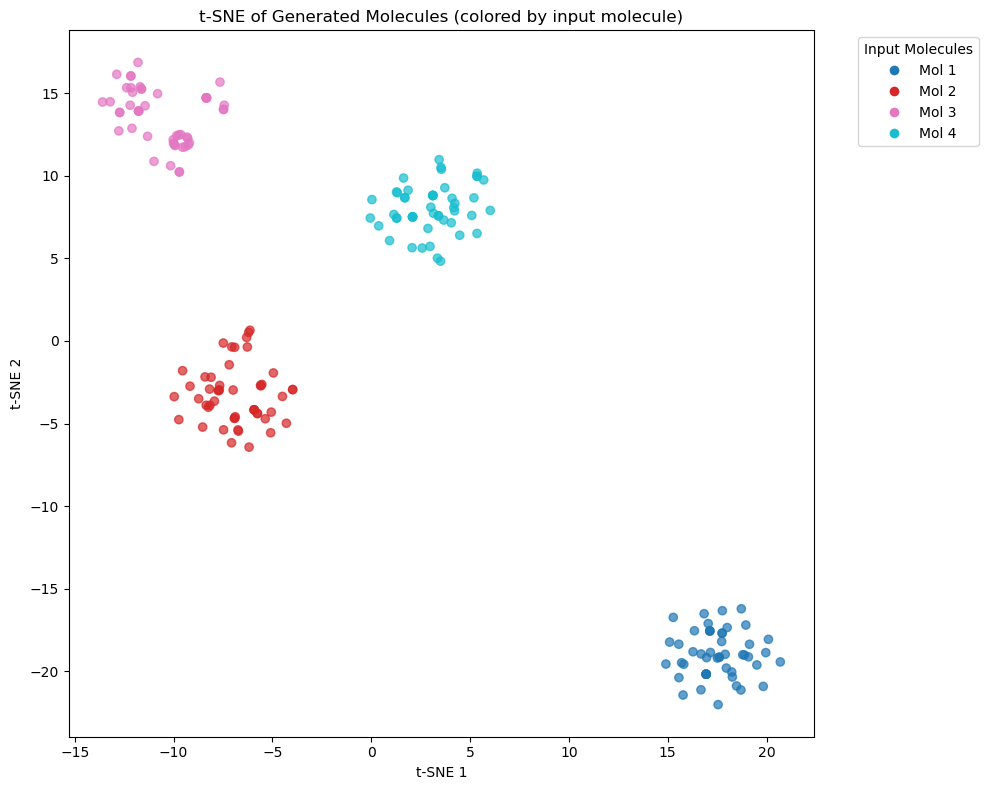

In [5]:
# t-SNE
if len(all_fps) > 0:
    print("\nRunning t-SNE...")
    X = np.array(all_fps)
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_tsne[:, 0], X_tsne[:, 1],
        c=all_labels, cmap='tab10', alpha=0.7
    )
    plt.title("t-SNE of Generated Molecules (colored by input molecule)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    # Extract actual mapping from scatter
    unique_labels = np.unique(all_labels)
    cmap = scatter.cmap
    norm = scatter.norm

    handles = []
    legend_labels = []
    for lbl in unique_labels:
        color = cmap(norm(lbl))   # <--- use same mapping as scatter
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, markersize=8))
        legend_labels.append(f"Mol {lbl+1}")

    plt.legend(handles, legend_labels, title="Input Molecules",
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig("tsne_generated_molecules.png", dpi=150)
    plt.show()
else:
    print("No valid fingerprints for t-SNE.")
